## SSP(Sleep Sensor Prediction)_JY [2]-[3]
* Time-series Classification
* GRU-ATT-GRU
* 특성 추가
* 5.9636025

In [17]:
# !pip install pandas numpy matplotlib seaborn scikit-learn torch xgboost lightgbm catboost pyarrow fastparquet py7zr

In [1]:
import os

directory_path = 'saved'

for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith(".ckpt"):
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

Deleted: saved\epoch=550-step=3857-v1.ckpt
Deleted: saved\epoch=550-step=3857.ckpt
Deleted: saved\epoch=999-step=7000.ckpt


In [12]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rc('axes', unicode_minus=False)

from datetime import datetime

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# import wandb
# from lightning.pytorch.loggers import WandbLogger

from argparse import ArgumentParser

parser = ArgumentParser(description="SSP_JY")

## DATA
parser.add_argument("--valid_path", default="./data", type=str)
parser.add_argument("--test_path", default="./data", type=str)
parser.add_argument('--window_size', default=24, type=int)  # 수면 시간 고려하여 설정하였음
parser.add_argument('--stride_size', default=1, type=int)  # 1시간 단위로 봄

## MHA
parser.add_argument('--num_head', default=8, type=int)
parser.add_argument('--hid_dim', default=128, type=int)

## TRAIN
parser.add_argument('--optimizer', default="adamw", type=str)
parser.add_argument("--learning_rate", default=1e-4, type=float)
parser.add_argument("--weight_decay", default=0, type=float)
parser.add_argument('--scheduler', default="step", type=str)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--epochs', default=1000, type=int)
parser.add_argument('--patience', default=100, type=int)

parser.add_argument('--cv', default=5, type=int)
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--mixed_precision', default=32, type=int)
parser.add_argument('--device', nargs='+', default=[0], type=int)
parser.add_argument('--num_workers', default=0, type=int)

args = parser.parse_args('')

# wandb.init(config=args, name='SSP_JY(GAG)', project="ETRI_Baseline")
# wandb_logger = WandbLogger(name='SSP_JY(GAG)', project="ETRI_Baseline")
# wandb.config.update(args)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CFG = {
    "WINDOW_SIZE" : args.window_size,
    "STRIDE_SIZE" : args.stride_size,
    "BATCH_SIZE" : args.batch_size,
    "EPOCHS"     : args.epochs,
    "PATIENCE"   : args.patience,
    "CV"         : args.cv,
    "SEED"       : args.seed,
    "VALID_PATH" : args.valid_path,
    "TEST_PATH"  : args.test_path,
}

def seed_everything(SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    L.seed_everything(SEED)

torch.set_float32_matmul_precision('high') 
seed_everything(CFG['SEED'])

idx = f"{parser.description}_{device}"
idx

Seed set to 42


'SSP_JY_cuda'

## dataloader.py

In [13]:
train_label = pd.read_csv('./data/val_label.csv')
test_label  = pd.read_csv('./data/answer_sample.csv')

train_label['date'] = pd.to_datetime(train_label['date'])
test_label['date']  = pd.to_datetime(test_label['date'])

In [14]:
train_data = pd.read_csv(os.path.join(CFG['VALID_PATH'],'train_data2.csv'))
test_data  = pd.read_csv(os.path.join(CFG['TEST_PATH'], 'test_data2.csv'))

train_data.shape, test_data.shape

((2520, 19), (2760, 19))

In [15]:
train_data_dict = {}

for id in [1, 2, 3, 4]:
    train_data_dict[f'train_macc_{id}'] = pd.read_csv(os.path.join(CFG['VALID_PATH'], f'train_macc_{id}-2.csv'))

test_data_dict = {}

for id in [5, 6, 7, 8]:
    test_data_dict[f'test_macc_{id}'] = pd.read_csv(os.path.join(CFG['TEST_PATH'], f'test_macc_{id}-2.csv'))

In [16]:
keys = train_data_dict.keys()
train_macc = pd.DataFrame()

for key in keys:
    train_macc = pd.concat([train_macc, train_data_dict[key]], axis=0)

keys = test_data_dict.keys()
test_macc = pd.DataFrame()

for key in keys:
    test_macc = pd.concat([test_macc, test_data_dict[key]], axis=0)

train_macc.fillna(0, inplace=True)
test_macc.fillna(0, inplace=True)

train_macc.shape, test_macc.shape

((2520, 6), (2760, 6))

In [17]:
train_data = train_data.merge(train_macc, on=['subject_id', 'hour'], how='left')
test_data  = test_data.merge(test_macc, on=['subject_id', 'hour'], how='left')

In [18]:
## categorical feature 처리

def Info2Idx(df, cat_feat):
    info2idx = {}
    for f in cat_feat:
        f_unique    = df[f].unique()
        info2idx[f] = {k:v+1 for v, k in enumerate(f_unique)}
    return info2idx

In [19]:
train_data['hour'] = pd.to_datetime(train_data['hour'])
test_data['hour']  = pd.to_datetime(test_data['hour'])

train_data['time'] = train_data['hour'].dt.hour.astype(float)
test_data['time']  = test_data['hour'].dt.hour.astype(float)

In [20]:
train_data['month'] = train_data['hour'].dt.month.astype(float)
test_data['month']  = test_data['hour'].dt.month.astype(float)

train_data['day'] = train_data['hour'].dt.dayofweek.astype(float)
test_data['day']  = test_data['hour'].dt.dayofweek.astype(float)

In [21]:
cat_feat = ['activity', 'month', 'max_ambience_cls']
total_cat = pd.concat([train_data.loc[:, cat_feat], test_data.loc[:, cat_feat]], axis=0)

info2idx = Info2Idx(total_cat, cat_feat)

## categorical 변수가 1개인 경우
# train_data[cat_feat[0]] = train_data[cat_feat[0]].map(info2idx[cat_feat[0]])
# test_data[cat_feat[0]]  = test_data[cat_feat[0]].map(info2idx[cat_feat[0]])

train_data[cat_feat] = train_data[cat_feat].apply(lambda x: x.map(info2idx[x.name]))
test_data[cat_feat]  = test_data[cat_feat].apply(lambda x: x.map(info2idx[x.name]))

# args.f_sizes = [len(info2idx[i])+1 for i in cat_feat]

In [22]:
train_data.columns

Index(['subject_id', 'hour', 'activity', 'distance', 'max_light_x',
       'mean_light_x', 'mean_burned_calories', 'mean_running_steps',
       'mean_steps', 'sum_burned_calories', 'sum_running_steps', 'sum_steps',
       'max_hr', 'mean_hr', 'max_light_y', 'mean_light_y',
       'app_total_use_time', 'app_mean_use_time', 'max_ambience_cls',
       'average_x', 'average_y', 'average_z', 'average_magnitude', 'time',
       'month', 'day'],
      dtype='object')

In [23]:
def make_dataset(X, Y, window_size=CFG['WINDOW_SIZE'], stride=CFG['STRIDE_SIZE'], for_train=True):
    
    if for_train:
        ids = [1,2,3,4]
        df_label = train_label.copy()
    else:
        ids = [5,6,7,8]
        df_label = test_label.copy()
    
    train_sequences = []
    valid_sequences = []

    train_sequences_labels = []
    valid_sequences_labels = []

    train_cols = [
        'activity', 'distance', 'mean_light_x', 'mean_burned_calories', 'mean_running_steps', 'mean_steps', 
        'mean_hr', 'mean_light_y', 'average_x', 'average_y', 'average_z', 'average_magnitude',
        'app_total_use_time', 'max_ambience_cls',
        # 'time', 'day', 'month'
                    ]
    
    label_cols = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3', 'S4']

    for id in ids:

        dates = df_label.loc[df_label.subject_id == id, 'date'].dt.date
        
        for idx, date in enumerate(dates):
            
            user_data  = X.loc[(X.subject_id == id) & (X.hour.dt.date == date), train_cols]
            user_label = Y.loc[(Y.subject_id == id) & (Y.date.dt.date == date), label_cols]

            user_data  = user_data.values
            user_label = user_label.values
            end = len(user_data) - window_size + 1
            
            for i in range(0, end, stride):
                if (idx == 0) & for_train :
                    valid_sequences.append(user_data[i : i + window_size, :])
                    valid_sequences_labels.append(user_label)
                elif for_train:
                    train_sequences.append(user_data[i : i + window_size, :])
                    train_sequences_labels.append(user_label)
                else:
                    train_sequences.append(user_data[i : i + window_size, :])
                    train_sequences_labels.append(user_label)
    
    if for_train:
        return np.array(train_sequences), np.array(train_sequences_labels), np.array(valid_sequences), np.array(valid_sequences_labels)
    else:
        return np.array(train_sequences), np.array(train_sequences_labels)

In [24]:
train_window_data, train_window_labels, valid_window_data, valid_window_labels = make_dataset(train_data, train_label, window_size=CFG['WINDOW_SIZE'], stride=CFG['STRIDE_SIZE'], for_train=True)
test_window_data, test_window_labels  = make_dataset(test_data, test_label, window_size=CFG['WINDOW_SIZE'], stride=CFG['STRIDE_SIZE'], for_train=False)

train_window_data.shape, train_window_labels.shape, valid_window_data.shape, valid_window_labels.shape, test_window_data.shape, test_window_labels.shape

((101, 24, 14),
 (101, 1, 7),
 (4, 24, 14),
 (4, 1, 7),
 (115, 24, 14),
 (115, 1, 7))

In [25]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        X = torch.tensor(self.X[index], dtype=torch.float32)
        
        if self.Y is not None:
            Y = torch.tensor(self.Y[index], dtype=torch.float32)
            return X, Y
        
        return X
    
    def __len__(self):
        return len(self.X)

## model.py

In [26]:
class GRUWithMultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(GRUWithMultiHeadAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.gru_in    = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc        = nn.Linear(hidden_size * 2, hidden_size)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads)
        self.gru_out   = nn.GRU(hidden_size, hidden_size, batch_first=True)
    
    def forward(self, x):

        outputs, hidden = self.gru_in(x)                                # BxTx(Direction * H)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim = 1))).unsqueeze(0)
        outputs = self.fc(outputs)                                      # BxTxH

        context_vec, _ = self.attention(outputs, outputs, outputs)      # BxTxH
        
        gru_input = context_vec[:, -1:, :]
        gru_output, _ = self.gru_out(gru_input, hidden)                 # BxTxH
        
        return gru_output

In [27]:
class BaseModel(nn.Module):
    def __init__(self, args, input_size=8, hidden_size=args.hid_dim):
        super(BaseModel, self).__init__()
        
        # 1D Convolution layers
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_size, hidden_size//2, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU()
            )
        
        # Bidirectional GRU with Attention
        self.gru_attention = GRUWithMultiHeadAttention(hidden_size//2, num_heads=args.num_head)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size//2, 7),
            nn.Sigmoid()
            )

    def forward(self, x):
        
        x = x.permute(0, 2, 1)                  # BxTxF -> BxFxT
        x = self.conv_block(x)                  # BxHxT'
        x = x.permute(0, 2, 1)                  # BxT'xH
        
        gru_output = self.gru_attention(x)      # BxT'x(Direction * H)
        output     = self.fc(gru_output[:, -1, :])  # Bx(Direction * H) -> Bx1

        return output.squeeze()

In [28]:
class BaseClassifier(L.LightningModule):
    def __init__(self, backbone, args):
        super().__init__()
        self.backbone = backbone

    def forward(self, x):
        predictions = self.backbone(x)
        return predictions

    def step(self, batch):
        x, y = batch
        y_hat = self.backbone(x)
        loss = nn.BCELoss()(y_hat, y.squeeze())
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        self.log("test_mae", loss, on_step=False, on_epoch=True, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y_hat = self.forward(x)
        return y_hat

    def configure_optimizers(self):
        if args.optimizer == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=args.learning_rate, momentum=0.9)
        if args.optimizer == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=args.learning_rate)
        if args.optimizer == "adamw":
            optimizer = torch.optim.AdamW(self.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        
        if args.scheduler == "none":
            return optimizer
        if args.scheduler == "step":
            scheduler = StepLR(
                optimizer=optimizer,
                step_size=250,
                gamma=0.05,
            )
            return [optimizer], [scheduler]
        if args.scheduler == "cosine":
            scheduler = CosineAnnealingLR(
                optimizer=optimizer,
                T_max=args.epochs,
                eta_min=1e-6,
            )
            return [optimizer], [scheduler]
        if args.scheduler == "plateau":
            scheduler = ReduceLROnPlateau(
                optimizer=optimizer,
                mode="min",
                factor=0.1,
                patience=2, # 2
                verbose=False,
            )
            return {"optimizer":optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [29]:
train_dataset = CustomDataset(train_window_data, train_window_labels)
valid_dataset = CustomDataset(valid_window_data, valid_window_labels)
test_dataset  = CustomDataset(test_window_data, test_window_labels)

train_loader  = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
valid_loader  = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)
test_loader   = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

##
model   = BaseClassifier(BaseModel(args, input_size=train_window_data.shape[2]), args)

early_stop_callback = EarlyStopping(
    monitor="train_loss", 
    patience=CFG['PATIENCE'], 
    mode="min"
    )

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(os.getcwd(),'saved'),
    save_top_k=1,
    verbose=False,
    monitor='train_loss',
    mode='min',
    )

trainer = L.Trainer(
    max_epochs=CFG["EPOCHS"], accelerator="auto", 
    enable_progress_bar=False,
    enable_model_summary=False,
    callbacks=[early_stop_callback, checkpoint_callback],
    devices=args.device#, logger=wandb_logger,
)

trainer.fit(model, train_loader, valid_loader)
checkpoint_callback.best_model_path

eval_dict = trainer.validate(model, dataloaders=valid_loader)[0]
valid_loss = eval_dict["val_loss"]

y_valid_preds = trainer.predict(model, dataloaders=valid_loader)
y_preds = trainer.predict(model, dataloaders=test_loader)

print(f"val_loss: {valid_loss}")
# wandb.log({'val_loss': valid_loss})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.6302194595336914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val_loss: 0.6302194595336914


In [30]:
final_valid_pred = torch.vstack(y_valid_preds)
final_valid_pred = final_valid_pred.cpu().numpy()
final_valid_pred = np.where(final_valid_pred > 0.5, 1, 0)
final_valid_pred.shape

(4, 7)

In [32]:
from sklearn.metrics import f1_score

total_f1 = 0
fina_valid_real = valid_window_labels.squeeze(1)

for i in range(7):

    if i == 2:
        weight = 1.0
    else:
        weight = 1.5
    
    f1 = f1_score(fina_valid_real[:,i], final_valid_pred[:,i])
    f1 *= weight
    total_f1 += f1

    print(f"f1_score_{i+1}: {f1}")
    # wandb.log({f'f1_score_{i+1}': f1})
print(f"total_f1: {total_f1}")
# wandb.log({'total_f1': total_f1})

f1_score_1: 1.2000000000000002
f1_score_2: 1.2857142857142856
f1_score_3: 0.8
f1_score_4: 0.0
f1_score_5: 1.0
f1_score_6: 0.75
f1_score_7: 1.0
total_f1: 6.035714285714286


In [33]:
final_preds = torch.vstack(y_preds)
final_preds = final_preds.cpu().numpy()
final_preds = np.where(final_preds > 0.5, 1, 0)
final_preds.shape

(115, 7)

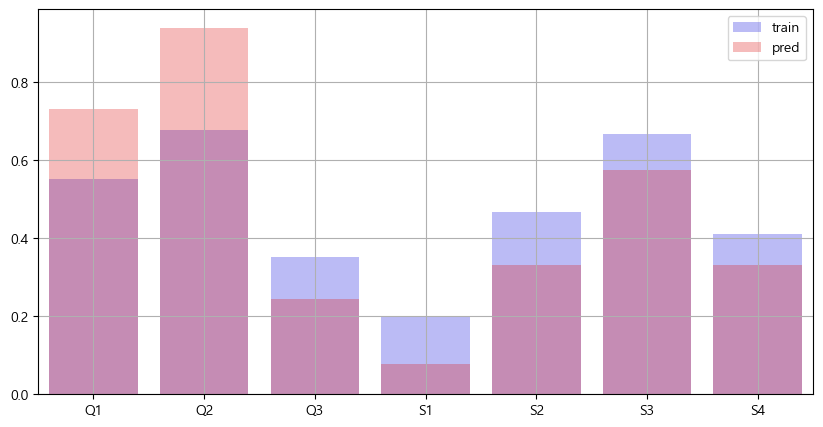

In [34]:
x = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3', 'S4']
for_barplot = pd.DataFrame(final_preds, columns=x)

plt.figure(figsize=(10,5))
sns.barplot(train_label.iloc[:, 2:].sum(0)/ 105, alpha=0.3, label='train', color='blue')
sns.barplot(for_barplot.sum(0)/115, alpha=0.3, label='pred', color='red')

plt.grid()
plt.legend()
plt.show()

In [35]:
for_barplot['subject_id'] = test_label.subject_id.values
print(for_barplot.groupby('subject_id').sum())

            Q1  Q2  Q3  S1  S2  S3  S4
subject_id                            
5            4  19   0   0   0   1   0
6           22  29   9   0   6  25   1
7           33  33  18   0  29  31  29
8           25  27   1   9   3   9   8


In [36]:
for_barplot.iloc[:, :].sum(0)/ 115, for_barplot.iloc[:, :].sum(0)

(Q1            0.730435
 Q2            0.939130
 Q3            0.243478
 S1            0.078261
 S2            0.330435
 S3            0.573913
 S4            0.330435
 subject_id    6.617391
 dtype: float64,
 Q1             84
 Q2            108
 Q3             28
 S1              9
 S2             38
 S3             66
 S4             38
 subject_id    761
 dtype: int64)

In [37]:
# wandb.finish()

In [39]:
now = datetime.now()
date = str(now.date()).replace('-', '_')
time = str(now.time()).replace(':', '_')

submmit = pd.read_csv('./data/answer_sample.csv')
submmit.iloc[:, 2:] = final_preds
submmit.to_csv(f'./submission/submission_{idx}_{date}_{time}.csv', index=False)

In [316]:
submmit

,subject_id,date,Q1,Q2,Q3,S1,S2,S3,S4
0,5,2023-11-05,0,1,0,1,0,0,0
1,5,2023-11-06,0,1,0,0,0,0,0
2,5,2023-11-07,1,1,0,0,0,0,0
3,5,2023-11-08,0,1,1,1,0,0,0
4,5,2023-11-09,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
110,8,2023-11-05,1,0,0,1,1,0,1
111,8,2023-11-06,1,0,0,1,0,0,0
112,8,2023-11-07,1,1,0,1,0,0,0
113,8,2023-11-08,0,1,0,0,0,0,0
